In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import numpy as np 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import IPython
import matplotlib.pyplot as plt
import math
import random
from scipy import interpolate
import re
from sklearn.metrics import roc_curve 
os.getcwd()

'd:\\courses\\Weaning\\COM4520-Darwin-weaing-of-ventilators\\Transformers\\Train_models'

# Data Preprocess before train

In [2]:
windows_df_360=pd.read_csv('windows_df_360.csv')
windows_df_360

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Time,ID,AdmissionDate,DischargeDate,CCOutcome,HospOutcome,VentMode,PS_Above_PEEP,EPAP_PEEP,SET_FIO2,...,PH,PaCO2,PaO2,LactateABG,HeartRate,ArtSystollic,ArtMAP,Temperature,empty_col,timestamps
0,02/05/2140 08:21,44162,01/05/2140 21:34,13/05/2140 10:53,A,NaN,PRVC,NaN,15.0,90.0,...,NaN,NaN,NaN,NaN,105.0,119.0,79.0,NaN,,5.375230e+09
1,02/05/2140 08:22,44162,01/05/2140 21:34,13/05/2140 10:53,A,NaN,PRVC,NaN,15.0,90.0,...,NaN,NaN,NaN,NaN,105.0,118.0,78.0,NaN,,5.375230e+09
2,02/05/2140 08:23,44162,01/05/2140 21:34,13/05/2140 10:53,A,NaN,PRVC,NaN,15.0,90.0,...,NaN,NaN,NaN,NaN,106.0,114.0,75.0,NaN,,5.375230e+09
3,02/05/2140 08:24,44162,01/05/2140 21:34,13/05/2140 10:53,A,NaN,PRVC,NaN,15.0,90.0,...,NaN,NaN,NaN,NaN,106.0,116.0,76.0,NaN,,5.375230e+09
4,02/05/2140 08:25,44162,01/05/2140 21:34,13/05/2140 10:53,A,NaN,PRVC,NaN,15.0,90.0,...,NaN,NaN,NaN,NaN,105.0,118.0,78.0,NaN,,5.375230e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3412435,08/06/2141 23:50,48017,24/04/2141 21:15,13/06/2141 10:37,A,A,PS/CPAP,5.0,5.0,35.0,...,NaN,NaN,NaN,NaN,116.0,200.0,133.0,NaN,,5.410018e+09
3412436,08/06/2141 23:51,48017,24/04/2141 21:15,13/06/2141 10:37,A,A,PS/CPAP,5.0,5.0,35.0,...,NaN,NaN,NaN,NaN,112.0,186.0,114.0,NaN,,5.410018e+09
3412437,08/06/2141 23:52,48017,24/04/2141 21:15,13/06/2141 10:37,A,A,PS/CPAP,5.0,5.0,35.0,...,NaN,NaN,NaN,NaN,110.0,187.0,113.0,NaN,,5.410018e+09
3412438,08/06/2141 23:53,48017,24/04/2141 21:15,13/06/2141 10:37,A,A,PS/CPAP,5.0,5.0,35.0,...,NaN,NaN,NaN,NaN,109.0,163.0,105.0,NaN,,5.410018e+09


In [4]:
string_column=['VentMode','CCOutcome','HospOutcome']
for column in string_column:
    label_column = windows_df_360[column]
    label_dict={}
    for label in label_column:
        if type(label)==float and np.isnan(label):
            continue
        else:
            if label not in label_dict.keys():
                label_dict[label]=1
            else:
                label_dict[label]+=1   
    print(column,label_dict)


VentMode {' PRVC': 630820, ' PC': 22102, ' PRVC+VS Trig': 328974, ' PS/CPAP': 1856995, ' LoFlo': 10, ' PRVC+VS No Trig': 410679, ' NIV PS': 917, ' Hood CPAP': 6, ' VS': 2474, ' PC+PS No Trig': 49079, ' VC': 2824, ' SIMV(PRVC)+PS': 8206, ' PC+PS Trig': 85789, ' SIMV(PC)+PS': 9618, ' NIV PC': 1, ' VC+VS No Trig': 2607, ' CPAP/ASB': 3, ' Facial CPAP': 2, ' Room Air': 3, ' VC+VS Trig': 1325, ' BI-VENT/APRV': 1, ' External CPAP Tube': 3, ' SIMV/ASB': 1, ' HiFlo': 1}
CCOutcome {' A': 2747520, ' D': 664920}
HospOutcome {' A': 2191680, ' D': 214560}


#### Therefore we can know that for CCOutcome and HospOutcome, only two input for 'A' and 'D', which will be set to 1 and 0

In [5]:
remove_column=['Time', 'ID', 'AdmissionDate', 'DischargeDate', 
       'VentMode', 'timestamps', 'PH', 'PaCO2', 'PaO2', 'LactateABG', 'Temperature','empty_col','HospOutcome']
for column in remove_column:
       windows_df_360.pop(column)
windows_df_360

,CCOutcome,PS_Above_PEEP,EPAP_PEEP,SET_FIO2,Spont_RR,Deadspace,SBI,P01,HeartRate,ArtSystollic,ArtMAP
0,A,NaN,15.0,90.0,0.0,33.2,NaN,NaN,105.0,119.0,79.0
1,A,NaN,15.0,90.0,0.0,33.2,NaN,NaN,105.0,118.0,78.0
2,A,NaN,15.0,90.0,0.0,33.4,NaN,NaN,106.0,114.0,75.0
3,A,NaN,15.0,90.0,0.0,33.3,NaN,NaN,106.0,116.0,76.0
4,A,NaN,15.0,90.0,0.0,33.2,NaN,NaN,105.0,118.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...
3412435,A,5.0,5.0,35.0,46.5,9.2,1188.0,1.2,116.0,200.0,133.0
3412436,A,5.0,5.0,35.0,42.8,9.0,3754.0,1.0,112.0,186.0,114.0
3412437,A,5.0,5.0,35.0,26.7,10.0,1415.0,0.6,110.0,187.0,113.0
3412438,A,5.0,5.0,35.0,28.5,9.9,2912.0,0.4,109.0,163.0,105.0


In [6]:
windows_df_360.replace({' A':1.0,' D':0.0},inplace=True)
windows_df_360

,CCOutcome,PS_Above_PEEP,EPAP_PEEP,SET_FIO2,Spont_RR,Deadspace,SBI,P01,HeartRate,ArtSystollic,ArtMAP
0,1.0,NaN,15.0,90.0,0.0,33.2,NaN,NaN,105.0,119.0,79.0
1,1.0,NaN,15.0,90.0,0.0,33.2,NaN,NaN,105.0,118.0,78.0
2,1.0,NaN,15.0,90.0,0.0,33.4,NaN,NaN,106.0,114.0,75.0
3,1.0,NaN,15.0,90.0,0.0,33.3,NaN,NaN,106.0,116.0,76.0
4,1.0,NaN,15.0,90.0,0.0,33.2,NaN,NaN,105.0,118.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...
3412435,1.0,5.0,5.0,35.0,46.5,9.2,1188.0,1.2,116.0,200.0,133.0
3412436,1.0,5.0,5.0,35.0,42.8,9.0,3754.0,1.0,112.0,186.0,114.0
3412437,1.0,5.0,5.0,35.0,26.7,10.0,1415.0,0.6,110.0,187.0,113.0
3412438,1.0,5.0,5.0,35.0,28.5,9.9,2912.0,0.4,109.0,163.0,105.0


## Generate model DataSet:

### interpolate for nan data

In [7]:
def interpolate_windows(windows_df,windows_size=360):
    windows_num=round(windows_df.shape[0]/windows_size)
    feature_num=windows_df.shape[1]
    feature_windows_list=[[]for i in range(feature_num)]
    for window_idx in range(windows_num):
        window_df = windows_df.iloc[window_idx*windows_size:(window_idx+1)*windows_size,:]
        for feature_idx in range(feature_num):
            feature_window=np.array(window_df.iloc[:,feature_idx])
            not_nan = np.where(np.isnan(feature_window)==False)[0]
            if len(not_nan)==0:
                feature_windows_list[feature_idx].append(np.array([0.0]*windows_size))
            elif len(not_nan)==1:
                not_nan_value = feature_window[not_nan][0]
                feature_windows_list[feature_idx].append(np.array([not_nan_value]*windows_size))
            elif len(not_nan)==windows_size:
                feature_windows_list[feature_idx].append(feature_window)
            else:
                if not_nan[0]>0:
                    recursive_left = list(range(0,not_nan[0]))
                    feature_window[recursive_left] = feature_window[not_nan[0]]
                    not_nan = np.concatenate((recursive_left,not_nan),axis=0)
                if not_nan[-1]<windows_size:
                    recursive_right = list(range(not_nan[-1],windows_size))
                    feature_window[recursive_right] = feature_window[not_nan[-1]]
                    not_nan = np.concatenate((not_nan,recursive_right),axis=0)
                not_nan_value = feature_window[not_nan]
                interp1d=interpolate.interp1d(not_nan,not_nan_value,kind='nearest')
                feature_windows_list[feature_idx].append(interp1d(list(range(0,windows_size))))
    for feature_idx in range(feature_num):            
        feature_windows_list[feature_idx]=np.concatenate(feature_windows_list[feature_idx])
    interpolate_dataset=np.array(feature_windows_list)
    return interpolate_dataset

#### Then normalise the dataframe

In [8]:
def normalization(df):
    float_column = ['PS_Above_PEEP', 'EPAP_PEEP', 'SET_FIO2',
    'Spont_RR', 'Deadspace', 'SBI', 'P01', 'HeartRate', 'ArtSystollic',
    'ArtMAP']
    range_list=[]
    min_list=[]
    for column in float_column:
        label_column = df[column]
        min_list.append(np.nanmin(label_column))
        _range = np.nanmax(label_column) - np.nanmin(label_column)
        range_list.append(_range)
        normalized_data = (label_column - np.nanmin(label_column)) / _range
        df[column] = normalized_data
    return df,min_list,range_list

In [9]:
def inverse_normalization(min_list,range_list,predict_data):
    predict_data_inverse=[]
    for i in range(10):
        predict_data_inverse.append(predict_data[i]*range_list[i]+min_list[i])
    return predict_data_inverse

#### load data from file name, and some preprocess job

In [10]:
def load(file_name):
    token_pattern=r'[0-9]'
    pattern=re.compile(token_pattern)
    windows_size=int(''.join(pattern.findall(file_name)))
    windows_df=pd.read_csv(file_name)
    remove_column=['Time', 'ID', 'AdmissionDate', 'DischargeDate', 
        'VentMode', 'timestamps', 'PH', 'PaCO2', 'PaO2', 'LactateABG', 'Temperature','empty_col','HospOutcome','CCOutcome']
    for column in remove_column:
        windows_df.pop(column)
    windows_df.replace({' A':1.0,' D':0.0},inplace=True)
    interpolate_df=pd.DataFrame(interpolate_windows(windows_df,windows_size=windows_size).T,columns=['PS_Above_PEEP', 'EPAP_PEEP', 'SET_FIO2',
        'Spont_RR', 'Deadspace', 'SBI', 'P01', 'HeartRate', 'ArtSystollic','ArtMAP'])
    return interpolate_df,windows_size

## Define Dataloader

In [11]:
class MyDataset(Dataset):
  def __init__(self, file_name, train_rate = 0.8, be_normalize=True):
    load_df,windows_size =load(file_name)
    x_train_set=[]
    if train_rate>0:
      train_windows_num=round(load_df.shape[0]*train_rate//windows_size)
      train_df=load_df.iloc[:train_windows_num*windows_size,:]
      if be_normalize:
        train_df,train_min,train_range=normalization(train_df)
      for windows_idx in range(train_windows_num):
        x_train_set.append(train_df.iloc[windows_idx*windows_size:(windows_idx+1)*windows_size,:].values)
    self.x_train=torch.tensor(np.array(x_train_set),dtype=torch.float32).cuda()
    self.train_range=train_range
    self.train_min=train_min
    x_test_set=[]
    if train_rate<1:
      test_df=load_df.iloc[train_windows_num*windows_size:,:]
      if be_normalize:
        test_df,test_min,test_range=normalization(test_df)
      test_windows_num=round(load_df.shape[0]/windows_size)-train_windows_num
      for windows_idx in range(test_windows_num):
        x_test_set.append(test_df.iloc[windows_idx*windows_size:(windows_idx+1)*windows_size,:].values)
    self.x_test=torch.tensor(np.array(x_test_set),dtype=torch.float32).cuda()
    self.test_range=test_range
    self.test_min=test_min
      
  def __len__(self,testset=False):
    if testset:
        return (self.x_test.shape[0])
    return (self.x_train.shape[0])

  def __getitem__(self,idx,testset=False):
    if testset:
      return (self.x_test[idx])
    return (self.x_train[idx])

train_set = MyDataset('windows_df_360.csv',be_normalize=True)

x_train = train_set.x_train
print(x_train.__getitem__(0))
print(x_train.shape[0])
x_test = train_set.x_test
print(train_set.__getitem__(0,testset=True))
print(x_test.shape[0])

C:\Users\16115\AppData\Local\Temp/ipykernel_7188/3068359317.py:9: DtypeWarning: Columns (5,22) have mixed types.Specify dtype option on import or set low_memory=False.
  load_df,windows_size =load(file_name)
C:\Users\16115\AppData\Local\Temp/ipykernel_7188/2181648760.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = normalized_data


tensor([[0.0000, 0.4286, 0.8734,  ..., 0.3276, 0.3410, 0.3950],
        [0.0000, 0.4286, 0.8734,  ..., 0.3276, 0.3381, 0.3900],
        [0.0000, 0.4286, 0.8734,  ..., 0.3310, 0.3266, 0.3750],
        ...,
        [0.0000, 0.4286, 0.4304,  ..., 0.3103, 0.3553, 0.4350],
        [0.0000, 0.4286, 0.4304,  ..., 0.3103, 0.3725, 0.4600],
        [0.0000, 0.4286, 0.4304,  ..., 0.3103, 0.3553, 0.4350]],
       device='cuda:0')
7583
tensor([[0.0000, 0.2917, 0.1139,  ..., 0.2850, 0.3066, 0.3450],
        [0.0000, 0.2917, 0.1139,  ..., 0.2617, 0.2579, 0.3250],
        [0.0000, 0.2917, 0.1139,  ..., 0.2710, 0.2579, 0.3350],
        ...,
        [0.0000, 0.2917, 0.0886,  ..., 0.2477, 0.3009, 0.3750],
        [0.0000, 0.2917, 0.0886,  ..., 0.2477, 0.3266, 0.3850],
        [0.0000, 0.2917, 0.0886,  ..., 0.2477, 0.3266, 0.3700]],
       device='cuda:0')
1896


## Create LSTM module

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1, batch_size = 50, feature_size=10):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).cuda()

        self.linear = nn.Linear(hidden_layer_size, output_size).cuda()

        self.hidden_cell = (torch.zeros(1,feature_size,self.hidden_layer_size).cuda(),
                            torch.zeros(1,feature_size,self.hidden_layer_size).cuda())
        self.batch_size = batch_size
        
        self.feature_size = feature_size
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(self.batch_size, self.feature_size, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(self.batch_size, self.feature_size, -1))
        return predictions[:,:,-1]
    def reset(self):
        self.hidden_cell = (torch.zeros(1,self.feature_size,self.hidden_layer_size).cuda(),
                    torch.zeros(1,self.feature_size,self.hidden_layer_size).cuda())

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
[0.08110283, 0.03352743, 0.00857638, 0.008903055, 0.008454906]


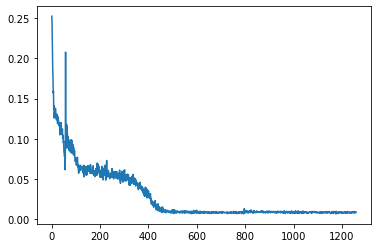

In [79]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)
batch_size=30
train_loader=DataLoader(x_train,batch_size=batch_size,shuffle=True)
model = LSTM(batch_size = batch_size, hidden_layer_size=100,feature_size=10).cuda()
# loss_function = nn.MSELoss(reduction='none').cuda()
loss_function = nn.L1Loss(reduction='none').cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)
record_epoch_loss=[]
record_batch_loss=[]
epochs = 5
windows_size = 360
for i in range(epochs):
    for j, batch_windows in enumerate(train_loader):
        if batch_windows.shape[0]!=batch_size:
            continue
        optimizer.zero_grad()
        batch_loss=torch.tensor([]).cuda()
        for steps in range(windows_size-1):
            inputvector = batch_windows[:,steps,:]
            y_pred = model(inputvector)
            y_true = batch_windows[:,steps+1,:]
            single_loss = loss_function(y_pred, y_true)
            batch_loss=torch.cat((batch_loss,single_loss))
        mean_loss = batch_loss.mean()
        mean_loss.backward()
        record_batch_loss.append(torch.Tensor.cpu(mean_loss).detach().numpy())
        optimizer.step()
        model.reset()
        # print(record_batch_loss[-1])
    record_epoch_loss.append(np.mean(record_batch_loss[i*(j-1):(i+1)*(j-1)]))

plt.plot(record_batch_loss)
print(record_epoch_loss)
def clear_cuda_cache():
    batch_loss.cpu()
    batch_windows.cpu()
    inputvector.cpu()
    single_loss.cpu()
    torch.cuda.empty_cache()
clear_cuda_cache()

## Predict for next 2 hours

In [16]:
def loss_predict(dataloader,minutes=15):
    test_batch_loss=[]
    for j, batch_windows in enumerate(dataloader):
        if batch_windows.shape[0]!=batch_size:
            continue
        batch_loss=torch.tensor([]).cuda()
        start_min=np.random.randint(windows_size-minutes)
        for steps in range(start_min,start_min+minutes):
            if steps == start_min:
                inputvector = batch_windows[:,steps,:]
            else:
                inputvector = y_pred
            y_pred = model(inputvector)
            y_true = batch_windows[:,steps+1,:]
            single_loss = loss_function(y_pred, y_true)
            batch_loss=torch.cat((batch_loss,single_loss))
        mean_loss = batch_loss.mean()
        test_batch_loss.append(torch.Tensor.cpu(mean_loss).detach().numpy())
        model.reset()
    clear_cuda_cache()
    return(np.mean(test_batch_loss))
    

In [32]:
predict_loss = []
batch_size=30
test_loader=DataLoader(x_test,batch_size=batch_size,shuffle=True)
predict_period=[15,30,45,60,90,120]
for period in predict_period:
    predict_loss.append(loss_predict(test_loader,minutes=period))
clear_cuda_cache()
print(predict_loss)

[0.03351742, 0.050676305, 0.06977348, 0.08859651, 0.12301518, 0.1554958]


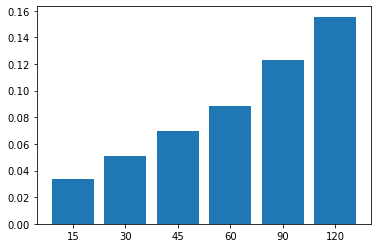

In [33]:
plt.bar(range(len(predict_period)),predict_loss,tick_label=predict_period)
plt.show()

[0.010639433, 0.0113878185, 0.012545523, 0.012532723, 0.013883014, 0.014480654, 0.0153557025, 0.015728848, 0.016172897, 0.01694863, 0.017530514, 0.018576436, 0.018909924, 0.01947888, 0.01980506, 0.020877184, 0.021059606, 0.021978455, 0.02256214, 0.022890491, 0.02385344, 0.024080656, 0.024466427, 0.025090339, 0.026054995, 0.026552496, 0.026846377, 0.027597358, 0.028346736, 0.029120581, 0.029200943, 0.029838586, 0.03031511, 0.031035235, 0.03167705, 0.032293238, 0.032930803, 0.032955833, 0.034079928, 0.03419273, 0.034819826, 0.035612013, 0.036002845, 0.036965635, 0.037046753, 0.037847195, 0.03841756, 0.038555652, 0.03928725, 0.040284343, 0.040413503, 0.041051693, 0.041517574, 0.04193331, 0.04292959, 0.04308914, 0.043738287, 0.044230822, 0.044920634]


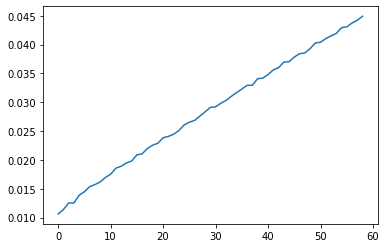

In [19]:
predict_loss = []
batch_size=30
test_loader=DataLoader(x_test,batch_size=batch_size,shuffle=True)
predict_period=list(range(1,60))
for period in predict_period:
    predict_loss.append(loss_predict(test_loader,minutes=period))
clear_cuda_cache()
print(predict_loss)
plt.plot(predict_loss)
plt.show()

### Try other input sequence size, such as 20, define new LSTM

LSTM_20(
  (lstm): LSTM(20, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
[0.023765737, 0.023215577, 0.023167888, 0.023168562, 0.023212122]


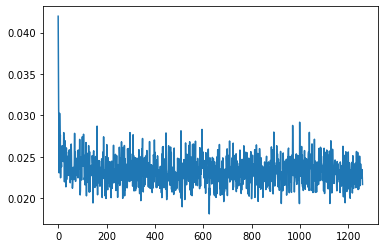

In [18]:
class LSTM_20(nn.Module):
    def __init__(self, input_size=20, hidden_layer_size=100, output_size=1, batch_size = 50, feature_size=10):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).cuda()

        self.linear = nn.Linear(hidden_layer_size, output_size).cuda()

        self.hidden_cell = (torch.zeros(1,feature_size,self.hidden_layer_size).cuda(),
                            torch.zeros(1,feature_size,self.hidden_layer_size).cuda())
        self.batch_size = batch_size
        
        self.feature_size = feature_size
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(self.batch_size, self.feature_size, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(self.batch_size, self.feature_size, -1))
        return predictions[:,:,-1]
    def reset(self):
        self.hidden_cell = (torch.zeros(1,self.feature_size,self.hidden_layer_size).cuda(),
                    torch.zeros(1,self.feature_size,self.hidden_layer_size).cuda())
        
batch_size=30
train_loader=DataLoader(x_train,batch_size=batch_size,shuffle=True)
model_20 = LSTM_20(batch_size = batch_size, hidden_layer_size=100, input_size=20, feature_size=10).cuda()
loss_function = nn.MSELoss(reduction='none').cuda()
optimizer_20 = torch.optim.Adam(model_20.parameters(), lr=0.001)
print(model_20)
record_epoch_loss=[]
record_batch_loss_20=[]
epochs = 5
windows_size = 360
for i in range(epochs):
    for j, batch_windows in enumerate(train_loader):
        if batch_windows.shape[0]!=batch_size:
            continue
        optimizer_20.zero_grad()
        batch_loss=torch.tensor([]).cuda()
        for steps in range(windows_size-20-1):
            inputvector = batch_windows[:,steps:steps+20,:]
            y_pred = model_20(inputvector)
            y_true = batch_windows[:,steps+20+1,:]
            single_loss = loss_function(y_pred, y_true)
            batch_loss=torch.cat((batch_loss,single_loss))
        mean_loss = batch_loss.mean()
        mean_loss.backward()
        record_batch_loss_20.append(torch.Tensor.cpu(mean_loss).detach().numpy())
        optimizer_20.step()
        model_20.reset()
        # print(record_batch_loss_20[-1])
    record_epoch_loss.append(np.mean(record_batch_loss_20[i*(j-1):(i+1)*(j-1)]))
print(record_epoch_loss)
plt.plot(record_batch_loss_20)
clear_cuda_cache()

In [21]:
def loss_predict_20(dataloader,minutes=15,batch_size=30):
    test_batch_loss=[]
    for j, batch_windows in enumerate(dataloader):
        if batch_windows.shape[0]!=batch_size:
            continue
        batch_loss=torch.tensor([]).cuda()
        start_min=np.random.randint(windows_size-minutes-20)
        for steps in range(start_min,start_min+minutes):
            if steps == start_min:
                inputvector = batch_windows[:,steps:steps+20,:]
            else:
                inputvector = torch.cat((batch_windows[:,steps:steps+19,:],torch.reshape(y_pred,(batch_size,1,10))),axis=1)
            y_pred = model_20(inputvector)
            y_true = batch_windows[:,steps+20+1,:]
            single_loss = loss_function(y_pred, y_true)
            batch_loss=torch.cat((batch_loss,single_loss))
        mean_loss = batch_loss.mean()
        test_batch_loss.append(torch.Tensor.cpu(mean_loss).detach().numpy())
        model_20.reset()
    clear_cuda_cache()
    return(np.mean(test_batch_loss))

[0.028880509, 0.028634531, 0.028639382, 0.028667973, 0.02878484, 0.02867416]


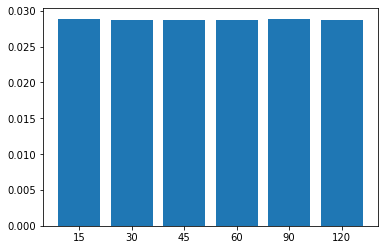

In [22]:
predict_loss_20 = []
predict_period=[15,30,45,60,90,120]
batch_size=30
test_loader=DataLoader(x_test,batch_size=batch_size,shuffle=True)
for period in predict_period:
    predict_loss_20.append(loss_predict_20(test_loader,minutes=period,batch_size=30))
clear_cuda_cache()
print(predict_loss_20)
plt.bar(range(len(predict_period)),predict_loss_20,tick_label=predict_period)
plt.show()

LSTM_60(
  (lstm): LSTM(60, 120)
  (linear): Linear(in_features=120, out_features=1, bias=True)
)
[0.023926057, 0.023221904, 0.023208452, 0.02322884, 0.023188038]


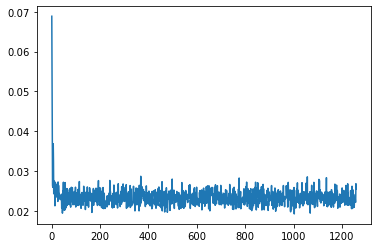

In [23]:
class LSTM_60(nn.Module):
    def __init__(self, input_size=60, hidden_layer_size=100, output_size=1, batch_size = 50, feature_size=10):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).cuda()

        self.linear = nn.Linear(hidden_layer_size, output_size).cuda()

        self.hidden_cell = (torch.zeros(1,feature_size,self.hidden_layer_size).cuda(),
                            torch.zeros(1,feature_size,self.hidden_layer_size).cuda())
        self.batch_size = batch_size
        self.feature_size = feature_size
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(self.batch_size, self.feature_size, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(self.batch_size, self.feature_size, -1))
        return predictions[:,:,-1]
    def reset(self):
        self.hidden_cell = (torch.zeros(1,self.feature_size,self.hidden_layer_size).cuda(),
                    torch.zeros(1,self.feature_size,self.hidden_layer_size).cuda())
        
batch_size=30
train_loader=DataLoader(x_train,batch_size=batch_size,shuffle=True)
model_60 = LSTM_60(batch_size = batch_size, hidden_layer_size=120, input_size=60, feature_size=10).cuda()
loss_function = nn.MSELoss(reduction='none').cuda()
optimizer_60 = torch.optim.Adam(model_60.parameters(), lr=0.001)
print(model_60)
record_epoch_loss=[]
record_batch_loss_60=[]
epochs = 5
windows_size = 360
for i in range(epochs):
    for j, batch_windows in enumerate(train_loader):
        if batch_windows.shape[0]!=batch_size:
            continue
        optimizer_60.zero_grad()
        batch_loss=torch.tensor([]).cuda()
        for steps in range(windows_size-60-1):
            inputvector = batch_windows[:,steps:steps+60,:]
            y_pred = model_60(inputvector)
            y_true = batch_windows[:,steps+60+1,:]
            single_loss = loss_function(y_pred, y_true)
            batch_loss=torch.cat((batch_loss,single_loss))
        mean_loss = batch_loss.mean()
        mean_loss.backward()
        record_batch_loss_60.append(torch.Tensor.cpu(mean_loss).detach().numpy())
        optimizer_60.step()
        model_60.reset()
        # print(record_batch_loss_60[-1])
    record_epoch_loss.append(np.mean(record_batch_loss_60[i*(j-1):(i+1)*(j-1)]))
print(record_epoch_loss)
plt.plot(record_batch_loss_60)
clear_cuda_cache()

[0.02877261, 0.028821064, 0.028823225, 0.028669676, 0.028737947, 0.02879618]


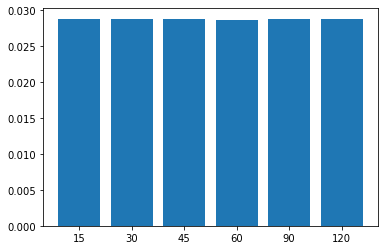

In [24]:
def loss_predict_60(dataloader,minutes=15,batch_size=30):
    test_batch_loss=[]
    for j, batch_windows in enumerate(dataloader):
        if batch_windows.shape[0]!=batch_size:
            continue
        batch_loss=torch.tensor([]).cuda()
        start_min=np.random.randint(windows_size-minutes-60)
        for steps in range(start_min,start_min+minutes):
            if steps == start_min:
                inputvector = batch_windows[:,steps:steps+60,:]
            else:
                inputvector = torch.cat((batch_windows[:,steps:steps+59,:],torch.reshape(y_pred,(batch_size,1,10))),axis=1)
            y_pred = model_60(inputvector)
            y_true = batch_windows[:,steps+60+1,:]
            single_loss = loss_function(y_pred, y_true)
            batch_loss=torch.cat((batch_loss,single_loss))
        mean_loss = batch_loss.mean()
        test_batch_loss.append(torch.Tensor.cpu(mean_loss).detach().numpy())
        model_60.reset()
    clear_cuda_cache()
    return(np.mean(test_batch_loss))

predict_loss_60 = []
predict_period=[15,30,45,60,90,120]
batch_size=30
test_loader=DataLoader(x_test,batch_size=batch_size,shuffle=True)
for period in predict_period:
    predict_loss_60.append(loss_predict_60(test_loader,minutes=period,batch_size=30))
clear_cuda_cache()
print(predict_loss_60)
plt.bar(range(len(predict_period)),predict_loss_60,tick_label=predict_period)
plt.show()

## Create Transformer model

In [25]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
#### positional encoding ####
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=360):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        # pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [26]:
class TransAm(nn.Module):
    def __init__(self, feature_size=10, num_layers=1, dropout=0):  # n times of head
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size).cuda()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=2, dropout=dropout).cuda()
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers).cuda()
        self.decoder = nn.Linear(feature_size, feature_size).cuda()  # not use decoder, actually decoder is not good as linear for predict time series
        self.init_weights()
        self.src_key_padding_mask = None#not need

    def init_weights(self):  
        initrange = 0.1
        self.decoder.bias.data.zero_().cuda()
        self.decoder.weight.data.uniform_(-initrange, initrange).cuda()

    def forward(self, src):
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask, self.src_key_padding_mask)
        output = self.decoder(output)
        return output

0.08934322
0.06309599
0.06209367
0.051681966
0.037182696
0.03262387
0.029728197
0.03778787
0.030765543
0.026238281
0.028594064
0.022808412
0.023802064
0.02381524
0.018869985
0.020788329
0.018150384
0.017029282
0.010789261
0.015130618
0.013092669
0.010972375
0.014481772
0.013472827
0.013132306
0.0090799555
0.01273421
0.01509216
0.012890256
0.012437884
0.008838087
0.01076372
0.01079888
0.007885016
0.011505414
0.008160879
0.00925922
0.008334903
0.009653221
0.010490463
0.010815102
0.008261283
0.009332644
0.009240181
0.011662326
0.011052154
0.011522712
0.008914793
0.006882883
0.009013319
0.0092485575
0.008948655
0.010133751
0.008898328
0.009640068
0.008054203
0.009758374
0.010094496
0.0106063355
0.0063977554
0.009701017
0.008236637
0.00785392
0.012436079
0.009471846
0.010536637
0.009827661
0.01010071
0.011294869
0.008161123
0.010498484
0.009885853
0.008569156
0.0098019
0.007549785
0.008261085
0.00761496
0.011160497
0.00975746
0.007776256
0.011316545
0.008838384
0.007921919
0.008640768
0.008

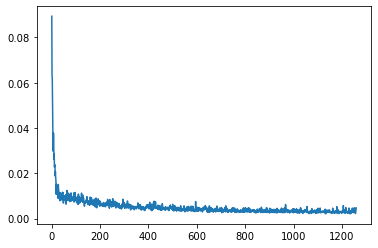

In [27]:
### train Transformer ####
clear_cuda_cache()
batch_size=30
train_loader=DataLoader(x_train,batch_size=batch_size,shuffle=True)
transformer_model = TransAm(feature_size=10, num_layers=1, dropout=0)
transformer_optimizer = torch.optim.AdamW(transformer_model.parameters(), lr=0.001)
transformer_scheduler = torch.optim.lr_scheduler.StepLR(transformer_optimizer, 3, gamma=0.96)
loss_function = nn.MSELoss(reduction='none').cuda()
best_val_loss = float("inf")
windows_size = 360
epochs = 5  # The number of epochs
record_epoch_loss=[]
record_batch_loss_transformer=[]

for i in range(epochs):
    for j, batch_windows in enumerate(train_loader):
        if batch_windows.shape[0]!=batch_size:
            continue
        transformer_optimizer.zero_grad()
        batch_loss=torch.tensor([]).cuda()
        for steps in range(windows_size-1):
            inputvector = batch_windows[:,steps,:].unsqueeze(1)
            y_pred = transformer_model(inputvector)
            y_true = batch_windows[:,steps+1,:].unsqueeze(1)
            single_loss = loss_function(y_pred, y_true)
            batch_loss=torch.cat((batch_loss,single_loss))
        mean_loss = batch_loss.mean()
        mean_loss.backward()
        record_batch_loss_transformer.append(torch.Tensor.cpu(mean_loss).detach().numpy())
        torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), 0.5)
        transformer_optimizer.step()
        print(record_batch_loss_transformer[-1])
    record_epoch_loss.append(np.mean(record_batch_loss_transformer[i*(j-1):(i+1)*(j-1)]))
    transformer_scheduler.step()
clear_cuda_cache()
plt.plot(record_batch_loss_transformer)
print(record_epoch_loss)

[0.032383244, 0.041108344, 0.04211297, 0.043441195, 0.043846667, 0.044198878]


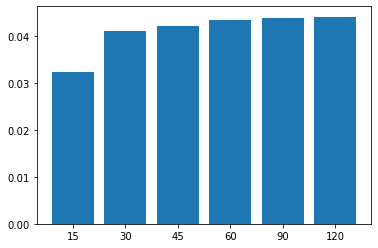

In [28]:
def loss_predict_transformer(dataloader,minutes=15):
    test_batch_loss=[]
    for j, batch_windows in enumerate(dataloader):
        if batch_windows.shape[0]!=batch_size:
            continue
        batch_loss=torch.tensor([]).cuda()
        start_min=np.random.randint(windows_size-minutes)
        for steps in range(start_min,start_min+minutes):
            if steps == start_min:
                inputvector = batch_windows[:,steps,:].unsqueeze(1)
            else:
                inputvector = y_pred
            y_pred = transformer_model(inputvector)
            y_true = batch_windows[:,steps+1,:].unsqueeze(1)
            single_loss = loss_function(y_pred, y_true)
            batch_loss=torch.cat((batch_loss,single_loss))
        mean_loss = batch_loss.mean()
        test_batch_loss.append(torch.Tensor.cpu(mean_loss).detach().numpy())
    
    clear_cuda_cache()
    return(np.mean(test_batch_loss))

predict_loss_transformer = []
predict_period=[15,30,45,60,90,120]
batch_size=30
test_loader=DataLoader(x_test,batch_size=batch_size,shuffle=True)
for period in predict_period:
    predict_loss_transformer.append(loss_predict_transformer(test_loader,minutes=period))
clear_cuda_cache()
print(predict_loss_transformer)
plt.bar(range(len(predict_period)),predict_loss_transformer,tick_label=predict_period)
plt.show()

# Do classification

### Load data with CCoutcome

In [20]:
def load_with_outcome(file_name):
    token_pattern=r'[0-9]'
    pattern=re.compile(token_pattern)
    windows_size=int(''.join(pattern.findall(file_name)))
    windows_df=pd.read_csv(file_name)
    remove_column=['Time', 'ID', 'AdmissionDate', 'DischargeDate', 
        'VentMode', 'timestamps', 'PH', 'PaCO2', 'PaO2', 'LactateABG', 'Temperature','empty_col','HospOutcome']
    for column in remove_column:
        windows_df.pop(column)
    windows_df.replace({' A':1.0,' D':0.0},inplace=True)
    interpolate_df=pd.DataFrame(interpolate_windows(windows_df,windows_size=windows_size).T,columns=['CCOutcome','PS_Above_PEEP', 'EPAP_PEEP', 'SET_FIO2',
        'Spont_RR', 'Deadspace', 'SBI', 'P01', 'HeartRate', 'ArtSystollic','ArtMAP'])
    return interpolate_df,windows_size

In [21]:
class ClassificationDataset(Dataset):
  def __init__(self, file_name, train_rate = 0.8, be_normalize=True, predict_period=30):
    load_df,windows_size = load_with_outcome(file_name)
    windows_size=predict_period
    x_train_set=[]
    if train_rate>0:
      train_windows_num=round(load_df.shape[0]*train_rate//windows_size)
      train_df=load_df.iloc[:train_windows_num*windows_size,:]
      if be_normalize:
        train_df,train_min,train_range=normalization(train_df)
      for windows_idx in range(train_windows_num):
        x_train_set.append(train_df.iloc[windows_idx*windows_size:(windows_idx+1)*windows_size,:].values)
    self.x_train=torch.tensor(np.array(x_train_set),dtype=torch.float32).cuda()
    self.train_range=train_range
    self.train_min=train_min
        
    x_test_set=[]
    if train_rate<1:
      test_df=load_df.iloc[train_windows_num*windows_size:,:]
      if be_normalize:
        test_df,test_min,test_range=normalization(test_df)
      test_windows_num=round(load_df.shape[0]/windows_size)-train_windows_num
      for windows_idx in range(test_windows_num):
        x_test_set.append(test_df.iloc[windows_idx*windows_size:(windows_idx+1)*windows_size,:].values)
    self.x_test=torch.tensor(np.array(x_test_set),dtype=torch.float32).cuda()
    self.test_range=test_range
    self.test_min=test_min
    
  def __len__(self,testset=False):
    if testset:
        return (self.x_test.shape[0])
    return (self.x_train.shape[0])

  def __getitem__(self,idx,testset=False):
    if testset:
      return (self.x_test[idx])
    return (self.x_train[idx])

## Set the predict period here(minutes), and depend on it to generate the train and test data set

In [22]:
minutes = 30
classification_train_set = ClassificationDataset('windows_df_360_last.csv',train_rate=0.8, be_normalize=True, predict_period=minutes)
classification_x_train = classification_train_set.x_train
print(classification_x_train.shape)
classification_x_test = classification_train_set.x_test
print(classification_x_test.shape)

C:\Users\16115\AppData\Local\Temp/ipykernel_7188/2181648760.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = normalized_data


torch.Size([3724, 30, 11])
torch.Size([932, 30, 11])


In [23]:
def performance_score(y_pred,y_true,print_performance=True):
    y_pred[y_pred>0.5]=1.
    y_pred[y_pred<=0.5]=0.
    y_pred=torch.Tensor.cpu(y_pred).detach().numpy()
    y_true=torch.Tensor.cpu(y_true).detach().numpy()
    performance_mark=[accuracy_score(y_true,y_pred),precision_score(y_true,y_pred,average='macro',zero_division=0)
                       ,recall_score(y_true,y_pred,average='macro'),f1_score(y_true,y_pred,average='macro')]
    if(print_performance):
        print('Accuracy:',performance_mark[0])
        print('Precision:', performance_mark[1])
        print('Recall:', performance_mark[2])
        print('F1-Score:', performance_mark[3])
    return performance_mark

Accuracy: 0.84
Precision: 0.8092105263157895
Recall: 0.7797619047619048
F1-Score: 0.7920997920997921


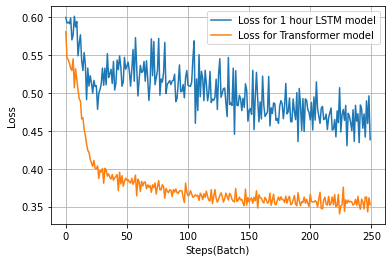

In [68]:
epochs = 250
hidden_size = 1000
num_classes = 1
learning_rate = 0.0001

feature_num = 10
predict_period=classification_x_train.shape[1]
input_size=predict_period*feature_num
batch_size=200
train_loader = DataLoader(classification_x_train,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(classification_x_test,batch_size=batch_size,shuffle=True)

class ClassificationNet(nn.Module) : 
    def __init__(self, input_size, hidden_size, num_classes) : 
        super(ClassificationNet, self).__init__()
        self.fc1 = nn.Linear(input_size , hidden_size)
        self.fc2 = nn.Linear(hidden_size , 100)
        self.fc3 = nn.Linear(100 , num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) : 
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

classification_model = ClassificationNet(input_size, hidden_size, num_classes).cuda()

criterionCE = nn.BCELoss().cuda()
# criterionCE = nn.CrossEntropyLoss().cuda()

classification_optimizer = torch.optim.Adam(classification_model.parameters(), lr=learning_rate)

clear_cuda_cache()

random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

record_epoch_loss=[]
record_batch_loss_classify=[]
test_epoch_loss=[]
test_batch_loss=[]

for i in range(epochs):
    for j, batch_windows in enumerate(train_loader):
        if batch_windows.shape[0]!=batch_size:
            continue
        
        inputvector = batch_windows[:,:,1:].reshape(batch_size,minutes*feature_num)
        y_pred = classification_model(inputvector)
        
        y_true = batch_windows[:,0,0].reshape(batch_size,1)
        batch_loss = criterionCE(y_pred, y_true).mean()
        
        classification_optimizer.zero_grad()
        batch_loss.backward()
        classification_optimizer.step()
        
        record_batch_loss_classify.append(torch.Tensor.cpu(batch_loss).detach().numpy())
    record_epoch_loss.append(np.mean(record_batch_loss_classify[i*(j-1):(i+1)*(j-1)]))
    # print("train loss: ",record_epoch_loss[-1])
    if i == epochs-1:
        train_performance = performance_score(y_pred,y_true)
        
    for k, batch_windows in enumerate(test_loader):
        if batch_windows.shape[0]!=batch_size:
            continue
        
        inputvector = batch_windows[:,:,1:].reshape(batch_size,minutes*feature_num)
        y_pred = classification_model(inputvector)
        
        y_true = batch_windows[:,0,0].reshape(batch_size,1)
        batch_loss = criterionCE(y_pred, y_true).mean()
        
        test_batch_loss.append(torch.Tensor.cpu(batch_loss).detach().numpy())
    test_performance = performance_score(y_pred,y_true,print_performance=False)
    test_epoch_loss.append(np.mean(test_batch_loss[i*(k-1):(i+1)*(k-1)]))
    # print("test loss: ",test_epoch_loss[-1])
fig,ax = plt.subplots()
plt.xlabel('Steps(Batch)')
plt.ylabel('Loss')
plt.plot(test_epoch_loss,label="Loss for 1 hour LSTM model" )
plt.plot(record_epoch_loss,label="Loss for Transformer model")
plt.legend()
plt.grid(True)
plt.show()
clear_cuda_cache()

In [25]:
def classification_predict(dataset,minutes=30):
    y_preds=torch.tensor([]).cuda()
    y_trues=torch.tensor([]).cuda()
    for j, windows in enumerate(dataset):
        if windows.shape[0]!=minutes:
            continue
        inputvector = windows[:,1:].reshape(1,minutes*feature_num)
        y_pred = classification_model(inputvector)
        y_preds=torch.cat((y_preds,y_pred))
        y_true = windows[0,0].reshape(1,1)
        y_trues=torch.cat((y_trues,y_true))
    y_probs=y_preds.clone().detach()
    performance=performance_score(y_preds,y_trues)
    return(performance,y_probs,y_trues)
            
clear_cuda_cache()
predict_loss_transformer = []
batch_size=200
predict_performance,clas_y_probs,clas_y_trues = classification_predict(classification_x_test,minutes=minutes)
print(predict_performance)
clear_cuda_cache()


Accuracy: 0.7907725321888412
Precision: 0.7432045779685265
Recall: 0.7246076029758665
F1-Score: 0.7324988703250961
[0.7907725321888412, 0.7432045779685265, 0.7246076029758665, 0.7324988703250961]


In [72]:
def lstm_predict(dataloader,minutes=30,batch_size=30):
    predict_output=[]
    for i, batch_windows in enumerate(dataloader):
        if batch_windows.shape[0]!=batch_size:
            continue
        y_true = batch_windows[:,0,0].reshape(batch_size,1,1)
        predict_output_period=torch.tensor([])
        for steps in range(minutes-1):
            if steps == 0:
                inputvector = batch_windows[:,steps,1:]
                predict_data = torch.cat((y_true.cpu(),inputvector.reshape(batch_size,1,10).cpu()),dim=2)
                predict_output_period = torch.cat((predict_output_period,predict_data.reshape(batch_size,1,11).cpu()),dim=1)
            else:
                inputvector = y_pred
            y_pred = model(inputvector.cuda())
            predict_data = torch.cat((y_true.cpu(),y_pred.reshape(batch_size,1,10).cpu()),dim=2)
            predict_output_period = torch.cat((predict_output_period,predict_data.reshape(batch_size,1,11).cpu()),dim=1)
            torch.cuda.empty_cache()
        predict_output.append(torch.Tensor.cpu(predict_output_period).detach().numpy())
        model.reset()
    predict_output = torch.tensor(predict_output).cuda()
    predict_output = predict_output.reshape(-1,minutes,11)
    return(predict_output)

batch_size=30
train_loader = DataLoader(classification_x_train.cpu(),batch_size=batch_size,shuffle=True)
test_loader = DataLoader(classification_x_test.cpu(),batch_size=batch_size,shuffle=True)
train_output=lstm_predict(train_loader,minutes=minutes,batch_size=batch_size)
predict_output=lstm_predict(test_loader,minutes=minutes,batch_size=batch_size)
print(predict_output.shape)

torch.Size([930, 30, 11])


In [73]:
def practice_predict(dataset,minutes=30):
    y_preds=torch.tensor([]).cuda()
    y_trues=torch.tensor([]).cuda()
    for j, windows in enumerate(dataset):
        if windows.shape[0]!=minutes:
            continue
        inputvector = windows[:,1:].reshape(1,minutes*10)
        y_pred = classification_model(inputvector)
        y_preds=torch.cat((y_preds,y_pred))
        y_true = windows[0,0].reshape(1,1)
        y_trues=torch.cat((y_trues,y_true))
    y_probs = y_preds.clone().detach()
    performance=performance_score(y_preds,y_trues)
    return(performance,y_preds,y_trues,y_probs)
clear_cuda_cache()
predict_loss_transformer = []
batch_size=30
print("Performance score on test data set:")
predict_accuracy_score,y_preds,y_trues,y_probs = practice_predict(predict_output,minutes=minutes)
print("\nPerformance score on train data set:")
train_accuracy_score,train_y_preds,train_y_trues,train_y_probs = practice_predict(train_output,minutes=minutes)
clear_cuda_cache()
# print(y_preds[0:50].T)
# print(y_trues[0:50].T)

Performance score on test data set:
Accuracy: 0.7989247311827957
Precision: 0.7586244913504521
Recall: 0.7201405951405951
F1-Score: 0.7341715847445579

Performance score on train data set:
Accuracy: 0.828763440860215
Precision: 0.8116580354881373
Recall: 0.6696736838889059
F1-Score: 0.7000239637513133


## Use LSTM to train a classification model

In [28]:
class lstm_ClassificationDataset(Dataset):
  def __init__(self, file_name, train_rate = 0.8, be_normalize=True):
    load_df,windows_size =da.load_with_outcome(file_name)
    x_train_set=[]
    if train_rate>0:
      train_windows_num=round(load_df.shape[0]*train_rate//windows_size)
      train_df=load_df.iloc[:train_windows_num*windows_size,:]
      if be_normalize:
        train_df,train_min,train_range=da.normalization(train_df)
      for windows_idx in range(train_windows_num):
        x_train_set.append(train_df.iloc[windows_idx*windows_size:(windows_idx+1)*windows_size,:].values)
    self.x_train=torch.tensor(np.array(x_train_set),dtype=torch.float32).cuda()
    self.train_range=train_range
    self.train_min=train_min
    x_test_set=[]
    if train_rate<1:
      test_df=load_df.iloc[train_windows_num*windows_size:,:]
      if be_normalize:
        test_df,test_min,test_range=da.normalization(test_df)
      test_windows_num=round(load_df.shape[0]/windows_size)-train_windows_num
      for windows_idx in range(test_windows_num):
        x_test_set.append(test_df.iloc[windows_idx*windows_size:(windows_idx+1)*windows_size,:].values)
    self.x_test=torch.tensor(np.array(x_test_set),dtype=torch.float32).cuda()
    self.test_range=test_range
    self.test_min=test_min
      
  def __len__(self,testset=False):
    if testset:
        return (self.x_test.shape[0])
    return (self.x_train.shape[0])

  def __getitem__(self,idx,testset=False):
    if testset:
      return (self.x_test[idx])
    return (self.x_train[idx])

minutes = 30
classification_train_set = lstm_ClassificationDataset('windows_df_360_last.csv',train_rate=0.8, be_normalize=True)
lstm_classification_x_train = classification_train_set.x_train
lstm_classification_x_test = classification_train_set.x_test
print(lstm_classification_x_test.shape)

In [ ]:
class lstm_ClassificationNet(nn.Module):
    def __init__(self, input_size=30, hidden_layer_size=1000, output_size=1, batch_size = 6, feature_size=10):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size*feature_size, hidden_layer_size).cuda()

        self.linear = nn.Linear(hidden_layer_size, output_size).cuda()

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).cuda(),
                            torch.zeros(1,1,self.hidden_layer_size).cuda())
        self.batch_size = batch_size
        
        self.feature_size = feature_size
        
        self.sigmoid = nn.Sigmoid()
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(self.batch_size, 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(self.batch_size, 1, -1))
        predictions = self.sigmoid(predictions)
        return predictions[:,:,-1]
    def reset(self):
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).cuda(),
                    torch.zeros(1,1,self.hidden_layer_size).cuda())

In [ ]:
def Classificationl_train(train_loader,optimizer,loss_function,model,minute=30,epochs=10,batch_size=30,windows_size=360):
    record_epoch_loss=[]
    record_batch_loss=[]
    for i in range(epochs):
        y_preds=batch_loss=torch.tensor([]).cuda()
        y_trues=batch_loss=torch.tensor([]).cuda()
        for j, batch_windows in enumerate(train_loader):
            if batch_windows.shape[0]!=batch_size:
                continue
            optimizer.zero_grad()
            batch_loss=torch.tensor([]).cuda()
            for steps in range(windows_size-minute-1):
                inputvector = batch_windows[:,steps:steps+minute,1:]
                y_pred = model(inputvector)
                y_preds=torch.cat((y_preds,y_pred))
                y_true = batch_windows[:,steps+minute,0].reshape(batch_size,1)
                y_trues=torch.cat((y_trues,y_true))
                single_loss = loss_function(y_pred, y_true).reshape(1)
                batch_loss=torch.cat((batch_loss,single_loss))
            mean_loss = batch_loss.mean()
            mean_loss.backward()
            record_batch_loss.append(torch.Tensor.cpu(mean_loss).detach().numpy())
            optimizer.step()
            model.reset()
            # print(record_batch_loss[-1])
        record_epoch_loss.append(np.mean(record_batch_loss[i*(j-1):(i+1)*(j-1)]))
        print(record_epoch_loss[-1])
        train_performance = performance_score(y_preds,y_trues,print_performance=True)
    print(record_epoch_loss)
    plt.plot(record_epoch_loss)
    batch_loss.cpu()
    batch_windows.cpu()
    inputvector.cpu()
    torch.cuda.empty_cache()
    
batch_size=60
classification_train_loader=DataLoader(lstm_classification_x_train,batch_size=batch_size,shuffle=True)
classification_model = lstm_ClassificationNet(batch_size = batch_size, hidden_layer_size=1000, input_size=30, feature_size=10).cuda()
classification_loss_function = nn.BCELoss().cuda()
classification_optimizer = torch.optim.Adam(classification_model.parameters(), lr=0.001)
print(classification_model)
epochs = 20
windows_size = 360
Classificationl_train(classification_train_loader,
                      classification_optimizer,
                      classification_loss_function,
                      classification_model,
                      minute=30,
                      epochs=epochs,
                      batch_size=batch_size,
                      windows_size=windows_size)

In [ ]:
def Classificationl_test(test_loader,model,minute=30,batch_size=39,windows_size=360):
    y_preds=batch_loss=torch.tensor([]).cuda()
    y_trues=batch_loss=torch.tensor([]).cuda()
    for j, batch_windows in enumerate(test_loader):
        if batch_windows.shape[0]!=batch_size:
            continue
        for steps in range(windows_size//minute):
            inputvector = batch_windows[:,steps*minute:steps*minute+minute,1:]
            y_pred = model(inputvector)
            y_preds=torch.cat((y_preds,y_pred))
            y_true = batch_windows[:,steps+minute,0].reshape(batch_size,1)
            y_trues=torch.cat((y_trues,y_true))
        model.reset()
        # print(record_batch_loss[-1])
    test_performance = performance_score(y_preds,y_trues,print_performance=True)
    batch_loss.cpu()
    batch_windows.cpu()
    inputvector.cpu()
    torch.cuda.empty_cache()
    
batch_size=60
classification_test_loader=DataLoader(lstm_classification_x_test,batch_size=batch_size,shuffle=True)
Classificationl_test(classification_test_loader,classification_model)

In [ ]:
def lstm_practice_predict(test_loader,model,batch_size=39):
    y_preds=batch_loss=torch.tensor([]).cuda()
    y_trues=batch_loss=torch.tensor([]).cuda()
    for j, batch_windows in enumerate(test_loader):
        if batch_windows.shape[0]!=batch_size:
            continue
        for steps in range(batch_windows.shape[0]//batch_size):
            inputvector = batch_windows[:,:,1:]
            y_pred = model(inputvector)
            y_preds=torch.cat((y_preds,y_pred))
            y_true = batch_windows[:,0,0].reshape(batch_size,1)
            y_trues=torch.cat((y_trues,y_true))
        model.reset()
        # print(record_batch_loss[-1])
    test_performance = performance_score(y_preds,y_trues,print_performance=True)
    batch_loss.cpu()
    batch_windows.cpu()
    inputvector.cpu()
    torch.cuda.empty_cache()
    return(test_performance,y_preds,y_trues)

predict_loss_transformer = []
predict_loader=DataLoader(predict_output,batch_size=60,shuffle=True)
predict_accuracy_score,y_preds,y_trues = lstm_practice_predict(predict_loader,classification_model)
print(y_preds[0:50].T)
print(y_trues[0:50].T)

## Performance for LSTM forcasting model and FFNN classification model system

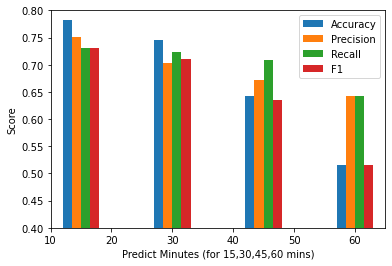

In [ ]:
accuracy_mark = [0.7817204301075269,0.7462365591397849,0.6433333333333333,0.5155555555555555]
precision_mark = [0.7516129032258064,0.7026139052718243,0.6718073593073592,0.643157530180091]
recall_mark = [0.7306826706676669,0.7225464100464101,0.7084815321477428,0.6417548500881834]
f1_mark = [0.7309472640105803,0.7098033070778924,0.6343588750555297,0.5155459860935525]
x = np.array([15,30,45,60])
total_width, n = 6, 4
width = total_width / n
x = x - (total_width - width) / 2
fig,ax = plt.subplots()
plt.xlabel('Predict Minutes (for 15,30,45,60 mins)')
plt.ylabel('Score')
plt.xlim(10,65)
plt.ylim(0.4,0.8)
plt.bar(x,accuracy_mark,width=width,label='Accuracy')
plt.bar(x + width,precision_mark,width=width,label='Precision')
plt.bar(x + width*2,recall_mark,width=width,label='Recall')
plt.bar(x + width*3,f1_mark,width=width,label='F1')
plt.legend()
plt.grid(False)
plt.show()

In [74]:
model_preds = torch.Tensor.cpu(y_preds).detach().numpy()
model_trues = torch.Tensor.cpu(y_trues).detach().numpy()
model_probs = torch.Tensor.cpu(y_probs).detach().numpy()
model_clas_probs = torch.Tensor.cpu(clas_y_probs).detach().numpy()
model_clas_trues = torch.Tensor.cpu(clas_y_trues).detach().numpy()

In [71]:
fper, tper, thresholds = roc_curve(model_trues, model_probs)

In [75]:
fper_clas, tper_clas, thresholds = roc_curve(model_clas_trues, model_clas_probs)

In [76]:
fper_1, tper_1, thresholds = roc_curve(model_trues, model_probs)

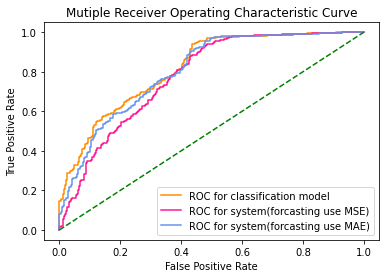

In [77]:
fig,ax = plt.subplots()
plt.plot(fper_clas, tper_clas, color='darkorange', label="ROC for classification model")
plt.plot(fper_1, tper_1, color='deeppink', label="ROC for system(forcasting use MSE)")
plt.plot(fper, tper, color='cornflowerblue', label="ROC for system(forcasting use MAE)")
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mutiple Receiver Operating Characteristic Curve')
plt.legend()
plt.show()